In [1]:
%pip install -q datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 75.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 9.1 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

ds = load_dataset('martingrzzler/mnemonics_benchmark')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___json/martingrzzler--mnemonics_benchmark-6cc75b71b93e3c15/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
%pip install git+https://github.com/boudinfl/pke.git
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/boudinfl/pke.git to /tmp/pip-req-build-ygtzlnvd
  Running command git clone --filter=blob:none --quiet https://github.com/boudinfl/pke.git /tmp/pip-req-build-ygtzlnvd
  Resolved https://github.com/boudinfl/pke.git to commit f2d4f5d2252c64d23defccd32fdac8809cfd7ce0
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 14.1 MB/s eta 0:00:00
  Created wheel for pke: filename=pke-2.0.0-py3-none-any.whl size=6160676 sha256=d230506d9aa48c49841348b844738a1d711fc3d79b9ec9827d521046b39864a5
  Stored in directory: /tmp/pip-ephem-wheel-cache-bowsnfu5/wheels/d5/46/97/85535b5b449f70b6a3c8d1138ce8587345876891e25bfe7954
Successfully built pke
2023-04-19 19:07:49.642818: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To 

In [4]:
import pke
import string
import re

stoplist = list(string.punctuation)
stoplist += pke.lang.stopwords.get('en')

def multi_partite_rank_extract(text, n):
    text = re.sub(r'<.*?>', '', text)
    multi_partite_rank = pke.unsupervised.MultipartiteRank()
    multi_partite_rank.load_document(input=text, language='en', stoplist=stoplist)
    pos = {'NOUN', 'PROPN', 'ADJ', 'VERB'}
    multi_partite_rank.candidate_selection(pos=pos)
    multi_partite_rank.candidate_weighting()
    return multi_partite_rank.get_n_best(n=n)

In [5]:
import nltk
stemmer = nltk.stem.PorterStemmer()

def any_in(keyphrase, input_words):
    input_stems = set([stemmer.stem(word) for word in input_words])
    keyphrase_stems = set([stemmer.stem(word) for word in keyphrase.split()])

    return len(input_stems & keyphrase_stems) > 0 

In [6]:
keys = ['gpt2xl_mnemonic', 'gpt3_mnemonic', 'gpt3_paragraph', 'wanikani_mnemonic']

In [7]:
def map_keywords_and_scores(example):
    for key in keys:
        keywords = multi_partite_rank_extract(example[key], n=10)
        example[key + '_keywords'] = [keyword for keyword, weight in keywords]
        example[key + '_keyword_scores'] = [weight for keyword, weight in keywords]

    return example

In [8]:
ds_keywords = ds.map(map_keywords_and_scores)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

In [77]:
sample = ds_keywords['train'][122]
input_words = [sample['kanji_meaning']] + sample['component_meanings'].split(',')

In [110]:
import numpy as np

def map_f1_scores(example):
    input_words = [example['kanji_meaning']] + example['component_meanings'].split(',')
    for key in keys:
        percentage = 0
        input_stems = set([stemmer.stem(word) for word in input_words])
        keywords_with_scores = list(zip(example[key + '_keywords'], example[key + '_keyword_scores']))
        for keyword, weight in keywords_with_scores[:len(input_words)]:
            if len(input_stems) == 0:
                break
            keyword_stems = set([stemmer.stem(word) for word in keyword.split()])
            for stem in keyword_stems:
                if stem in input_stems:
                    percentage += 1   
                    input_stems.remove(stem)
                    break
        if key == 'wanikani_mnemonic' and percentage/len(input_words) < 0.05:
            print(input_words)
            print(keywords_with_scores)
        example[key + '_score'] = percentage / len(input_words)
    return example

In [111]:
ds_scores = ds_keywords.map(map_scores)

Map:   0%|          | 0/190 [00:00<?, ? examples/s]

['woman', 'woman']
[('know', 0.2645136522790331), ('radical', 0.24981500866959327), ('means', 0.2337486109745342), ('woman', 0.17238380418114313), ('swell', 0.07953892389569639)]
['from', 'stairs']
[('place', 0.22450958539820004), ('picture', 0.17456973275493587), ('stairs', 0.15499627600196586), ('room', 0.13785001924165205), ('climbing stairs', 0.09893911923079596), ('picture going', 0.09053930021228185), ('way', 0.07277426677586267), ('want', 0.04582170038430562)]
['dragon', 'dragon']
[('know', 0.37748681170581977), ('radicals', 0.27751573963705295), ('dragon radical', 0.21910279309516373), ('dragon', 0.12589465556196397)]
['street', 'street']
[('radical', 0.2769765582158278), ('look', 0.21940826145178227), ('know', 0.21651074473859275), ('street', 0.16622908319842558), ('radical street', 0.12087535239537173)]
['sunlight', 'triceratops', 'pi']
[('absorb', 0.08093911774290558), ('light', 0.05906103635238351), ('round', 0.05688279366735407), ('pi shaped', 0.05017442622529271), ('shado

In [112]:
from scipy.stats import f_oneway
def anova(ds, feature):
    f, p = f_oneway(*[ds[key+'_'+feature] for key in keys])
    return f, p

In [113]:
anova(ds_scores['train'], 'score')

(130.90599618115883, 2.692954856488103e-68)

In [107]:
import matplotlib.pyplot as plt
import numpy as np

def box_plot(ds,title, feature, labels=['GPT-2','GPT-3 (mnemonic)','GPT-3 (paragraph)','WaniKani']):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title)
    ax.boxplot([ds[key+'_'+feature] for key in keys], labels=labels, showmeans=True, showfliers=False)
    plt.show()

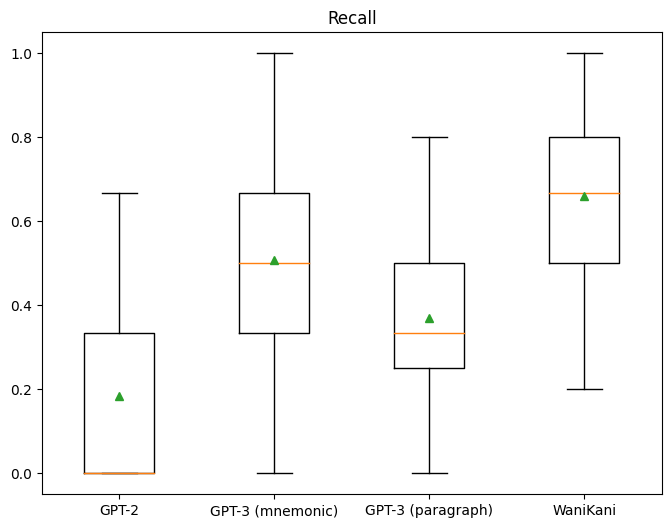

In [126]:
box_plot(ds_scores['train'], 'Recall', 'score')

In [71]:
from scipy.stats import tukey_hsd

def tukey(ds, feature):
    data = [ds[key+'_'+feature] for key in keys]
    res = tukey_hsd(*data)
    print(res)

In [115]:
tukey(ds_scores['train'], 'score')

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.324     0.000    -0.388    -0.259
 (0 - 2)     -0.186     0.000    -0.250    -0.121
 (0 - 3)     -0.476     0.000    -0.540    -0.411
 (1 - 0)      0.324     0.000     0.259     0.388
 (1 - 2)      0.138     0.000     0.073     0.202
 (1 - 3)     -0.152     0.000    -0.217    -0.088
 (2 - 0)      0.186     0.000     0.121     0.250
 (2 - 1)     -0.138     0.000    -0.202    -0.073
 (2 - 3)     -0.290     0.000    -0.355    -0.226
 (3 - 0)      0.476     0.000     0.411     0.540
 (3 - 1)      0.152     0.000     0.088     0.217
 (3 - 2)      0.290     0.000     0.226     0.355



In [41]:
def mean_std(ds, feature):
    return [(key, np.mean(ds[key+'_'+feature]), np.std(ds[key+'_'+feature])) for key in keys]

In [117]:
mean_std(ds_scores['train'], 'score')

[('gpt2xl_mnemonic', 0.18491228070175433, 0.2216310310916583),
 ('gpt3_mnemonic', 0.5084210526315789, 0.25099653645254283),
 ('gpt3_paragraph', 0.37061403508771934, 0.24099677907041528),
 ('wanikani_mnemonic', 0.6607894736842105, 0.2580441893007605)]

<Axes: >

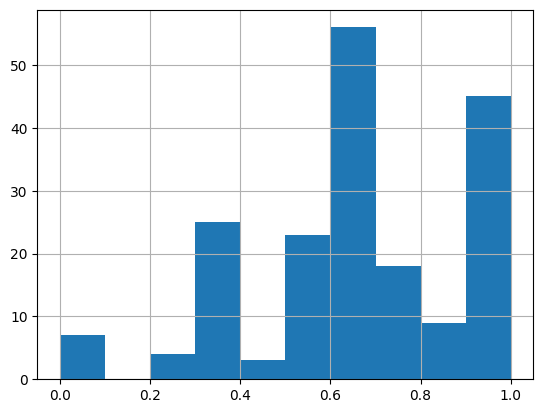

In [125]:
ds_scores['train'].to_pandas()[keys[3]+'_score'].hist()

In [119]:
ds_scores['train'].to_pandas().sort_values(by=keys[3]+'_score', ascending=True)[:3]

,kanji_id,component_meanings,wanikani_mnemonic,kanji_meaning,gpt2xl_mnemonic,gpt3_paragraph,gpt3_mnemonic,gpt2xl_mnemonic_keywords,gpt2xl_mnemonic_keyword_scores,gpt3_mnemonic_keywords,gpt3_mnemonic_keyword_scores,gpt3_paragraph_keywords,gpt3_paragraph_keyword_scores,wanikani_mnemonic_keywords,wanikani_mnemonic_keyword_scores,gpt2xl_mnemonic_score,gpt3_mnemonic_score,gpt3_paragraph_score,wanikani_mnemonic_score
98,1873,dragon,The <radical>dragon</radical> radical is the s...,dragon,This is a rush transcript. Copy may not be in ...,"Once upon a time, there lived a powerful drago...","Once upon a time, there were two dragons, one ...","[dragon, head, eyes, subscribe, future work, n...","[0.1377566832446005, 0.1122739135609404, 0.097...","[day, dragons, loved, friends, fly, explore ne...","[0.08275113444490478, 0.07208218368920868, 0.0...","[powerful dragon, gold, lived, breathed fire, ...","[0.11106870780658809, 0.07320079527159133, 0.0...","[know, radicals, dragon radical, dragon]","[0.37748681170581977, 0.27751573963705295, 0.2...",0.5,0.5,0.500000,0.0
163,1877,blade,The radical <radical>blade</radical> and the k...,blade,"It's been a long time coming, but it looks lik...","The blade of the sword was razor sharp, glinti...",Once upon a time there was a brave knight name...,"[star wars, big screen, episode vii, blade run...","[0.12782858367661173, 0.11728663484579328, 0.1...","[blades, kingdom, battle, evil forces, threate...","[0.17268500855653454, 0.0752699200769746, 0.07...","[razor sharp, blade, sword, glinting, utmost c...","[0.1273355102201708, 0.12248438707274768, 0.11...","[know, radicals, radical blade, blade]","[0.3534563270004184, 0.3300039001519909, 0.210...",0.0,0.5,0.500000,0.0
122,567,"triceratops,pi",You see a <radical>triceratops</radical> in th...,sunlight,"It's been triceratops time for a while now, an...","The triceratops lived in the Mesozoic era, a t...","Once upon a time, there was a triceratops name...","[jurassic park, résistance, trespasser, pièce,...","[0.13016797801420946, 0.08610052887804845, 0.0...","[walk, explore, rays, sun, day, sunshine, pi d...","[0.06812058406951411, 0.04386016946820342, 0.0...","[triceratops lived, time, mesozoic era, length...","[0.06564683710394531, 0.05725550051584591, 0.0...","[absorb, light, round, pi shaped, shadow, imag...","[0.08093911774290558, 0.05906103635238351, 0.0...",0.0,0.0,0.333333,0.0


<Axes: >

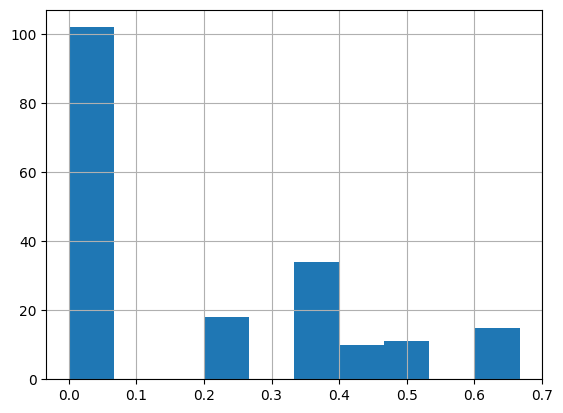

In [120]:
ds_scores['train'].to_pandas()[keys[0]+'_score'].hist()

In [45]:
import numpy as np

def group_variance(ds, score_name):
    within_group_vars = [np.var(ds[key+'_'+score_name]) for key in keys]
    total_mean = np.mean([score for key in keys for score in ds[key+'_'+score_name]])
    between_group_var = np.sum([(np.mean(ds[key+'_'+score_name]) - total_mean) ** 2 for key in keys]) / (len(keys) - 1)
    return within_group_vars, between_group_var

In [121]:
group_variance(ds_scores['train'], 'score')

([0.049120313942751605,
  0.06299926131117267,
  0.05807944752231455,
  0.06658680363188674],
 0.041000905406791834)

In [122]:
def print_mnemonic(key):
    def inner(x):
        print(x['kanji_meaning'], x['component_meanings'])
        print(x[key+'_keywords'])
        print(x[key])
        print()
    return inner

In [124]:
ds_scores['train'].to_pandas().sort_values('wanikani_mnemonic_score', ascending=False).iloc[:2].apply(print_mnemonic('wanikani_mnemonic'), axis=1)

pillar tree,east
['tree' 'pillar' 'east' 'looks' 'tall' 'straight' 'branches' 'leaves'
 'happens' 'alive']
There’s a <radical>tree</radical> in the <radical>east</radical> that looks like a <kanji>pillar</kanji>. The tree is tall and straight and does not have any leaves or branches. The tree is basically a big wooden pillar that just happens to be alive still. Look at this big tree pillar over in the east. You always know where east is because of it.

excellent leader,dirt
['dirt' 'leader gets' 'excellent' 'build' 'took' 'skilled' 'great'
 'leading' 'house' 'imagine']
A <radical>leader</radical> gets double the <radical>dirt</radical> to build on if he's the most <kanji>excellent</kanji> and most <kanji>skilled</kanji> of all the leaders. You don't think dirt is so great? Well what if I took the dirt you own away from you? Your house is on that dirt. It's mine now. Get outta here. Imagine being so excellent at leading, that you get double the dirt that everyone else gets.



95    None
40    None
dtype: object

woman, catapult, recreation

prediction = woman, wellness, garbage

recall = TP / (TP + FN)
recall = 